In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type
import cleansing_helper as CleansingHelper

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [5]:
df.drop(['RNF'], axis=1, inplace=True)
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [6]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0


In [7]:
convert_type = {'H':1, 'M':2, 'L':3}

def mapping_type(item):
    if item in convert_type.keys():
      return convert_type[item]
    else:
      return -1

In [8]:
# encode type to be number

df['Type'] = df['Type'].apply(mapping_type)

In [9]:
df.head(15)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,3,L47182,3,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,4,L47183,3,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,5,L47184,3,298.2,308.7,1408,40.0,9,0,0,0,0,0
5,6,M14865,2,298.1,308.6,1425,41.9,11,0,0,0,0,0
6,7,L47186,3,298.1,308.6,1558,42.4,14,0,0,0,0,0
7,8,L47187,3,298.1,308.6,1527,40.2,16,0,0,0,0,0
8,9,M14868,2,298.3,308.7,1667,28.6,18,0,0,0,0,0
9,10,M14869,2,298.5,309.0,1741,28.0,21,0,0,0,0,0


### Feature Engineering

In [10]:
# The importance feature of power failure  is Power then we create the Power feature 
# Power(kW) = Torque (N.m) x Speed (rpm)

df['Power'] = df['Torque'] * df['RotationalSpeed']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4


In [11]:
# The importance feature of heat dissipation failure  is temperature
df['AirDiff'] = df['ProcessTemp'] - df['AirTemp']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5


In [12]:
df['TorqueToolWear'] = df['Torque'] * df['ToolWear']

In [29]:
pd.set_option('display.max_columns', None)
df[(df['TorqueToolWear'] >= 11000) & (df['Type'] == 3)].head(3)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff,TorqueToolWear
69,70,L47249,3,298.9,309.0,1410,65.7,191,1,0,0,1,1,92637.0,10.1,12548.7
160,161,L47340,3,298.4,308.2,1282,60.7,216,1,0,0,0,1,77817.4,9.8,13111.2
161,162,L47341,3,298.3,308.1,1412,52.3,218,1,0,0,0,1,73847.6,9.8,11401.4


In [30]:
pd.set_option('display.max_columns', None)
df[(df['TorqueToolWear'] >= 12000) & (df['Type'] == 2)].head(3)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff,TorqueToolWear
1324,1325,M16184,2,298.8,310.1,1243,74.5,194,1,0,0,1,1,92603.5,11.3,14453.0
3935,3936,M18795,2,302.6,311.6,1227,68.2,187,1,0,0,0,1,83681.4,9.0,12753.4
4024,4025,M18884,2,302.1,311.0,1351,60.3,207,1,0,0,0,1,81465.3,8.9,12482.1


In [31]:
pd.set_option('display.max_columns', None)
df[(df['TorqueToolWear'] >= 13000) & (df['Type'] == 1)].head(3)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff,TorqueToolWear
5399,5400,H34813,1,302.8,312.4,1411,53.8,246,1,0,0,0,1,75911.8,9.6,13234.8
5909,5910,H35323,1,300.7,310.2,1364,65.3,208,1,1,0,1,1,89069.2,9.5,13582.4


In [49]:
df.head(5)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff,TorqueToolWear
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5,0.0
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5,138.9
2,3,L47182,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,74001.2,10.4,247.0
3,4,L47183,3,298.2,308.6,1433,39.5,7,0,0,0,0,0,56603.5,10.4,276.5
4,5,L47184,3,298.2,308.7,1408,40.0,9,0,0,0,0,0,56320.0,10.5,360.0


### Function for check behavior

## Plot Feature

In [14]:
def get_moving_average(df, window_size=10):
    windows = df.rolling(window_size)
    moving_average = windows.mean()
    moving_averages_list = moving_average.tolist()
    final_list = moving_averages_list[window_size - 1:]
    
    return(final_list)

In [65]:
def plot_feature_class(df, feautures, label, window_size=10):
    fig, ax = plt.subplots(len(feautures)+1, 1, figsize=(42,25))
    sns.lineplot(ax=ax[0], x=range(df.shape[0]), y=label, data=df, alpha=0.5, color='red' )
    
    
    for idx, feature in enumerate(feautures):
        sns.lineplot(ax=ax[idx+1], x=range(df.shape[0]), y=feautures[idx], data=df, alpha=0.5 )
        #sns.lineplot(ax=ax[idx+1], x=range(window_size-1, df.shape[0]), y=get_moving_average(df[feature], window_size), alpha=0.5 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
        sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )

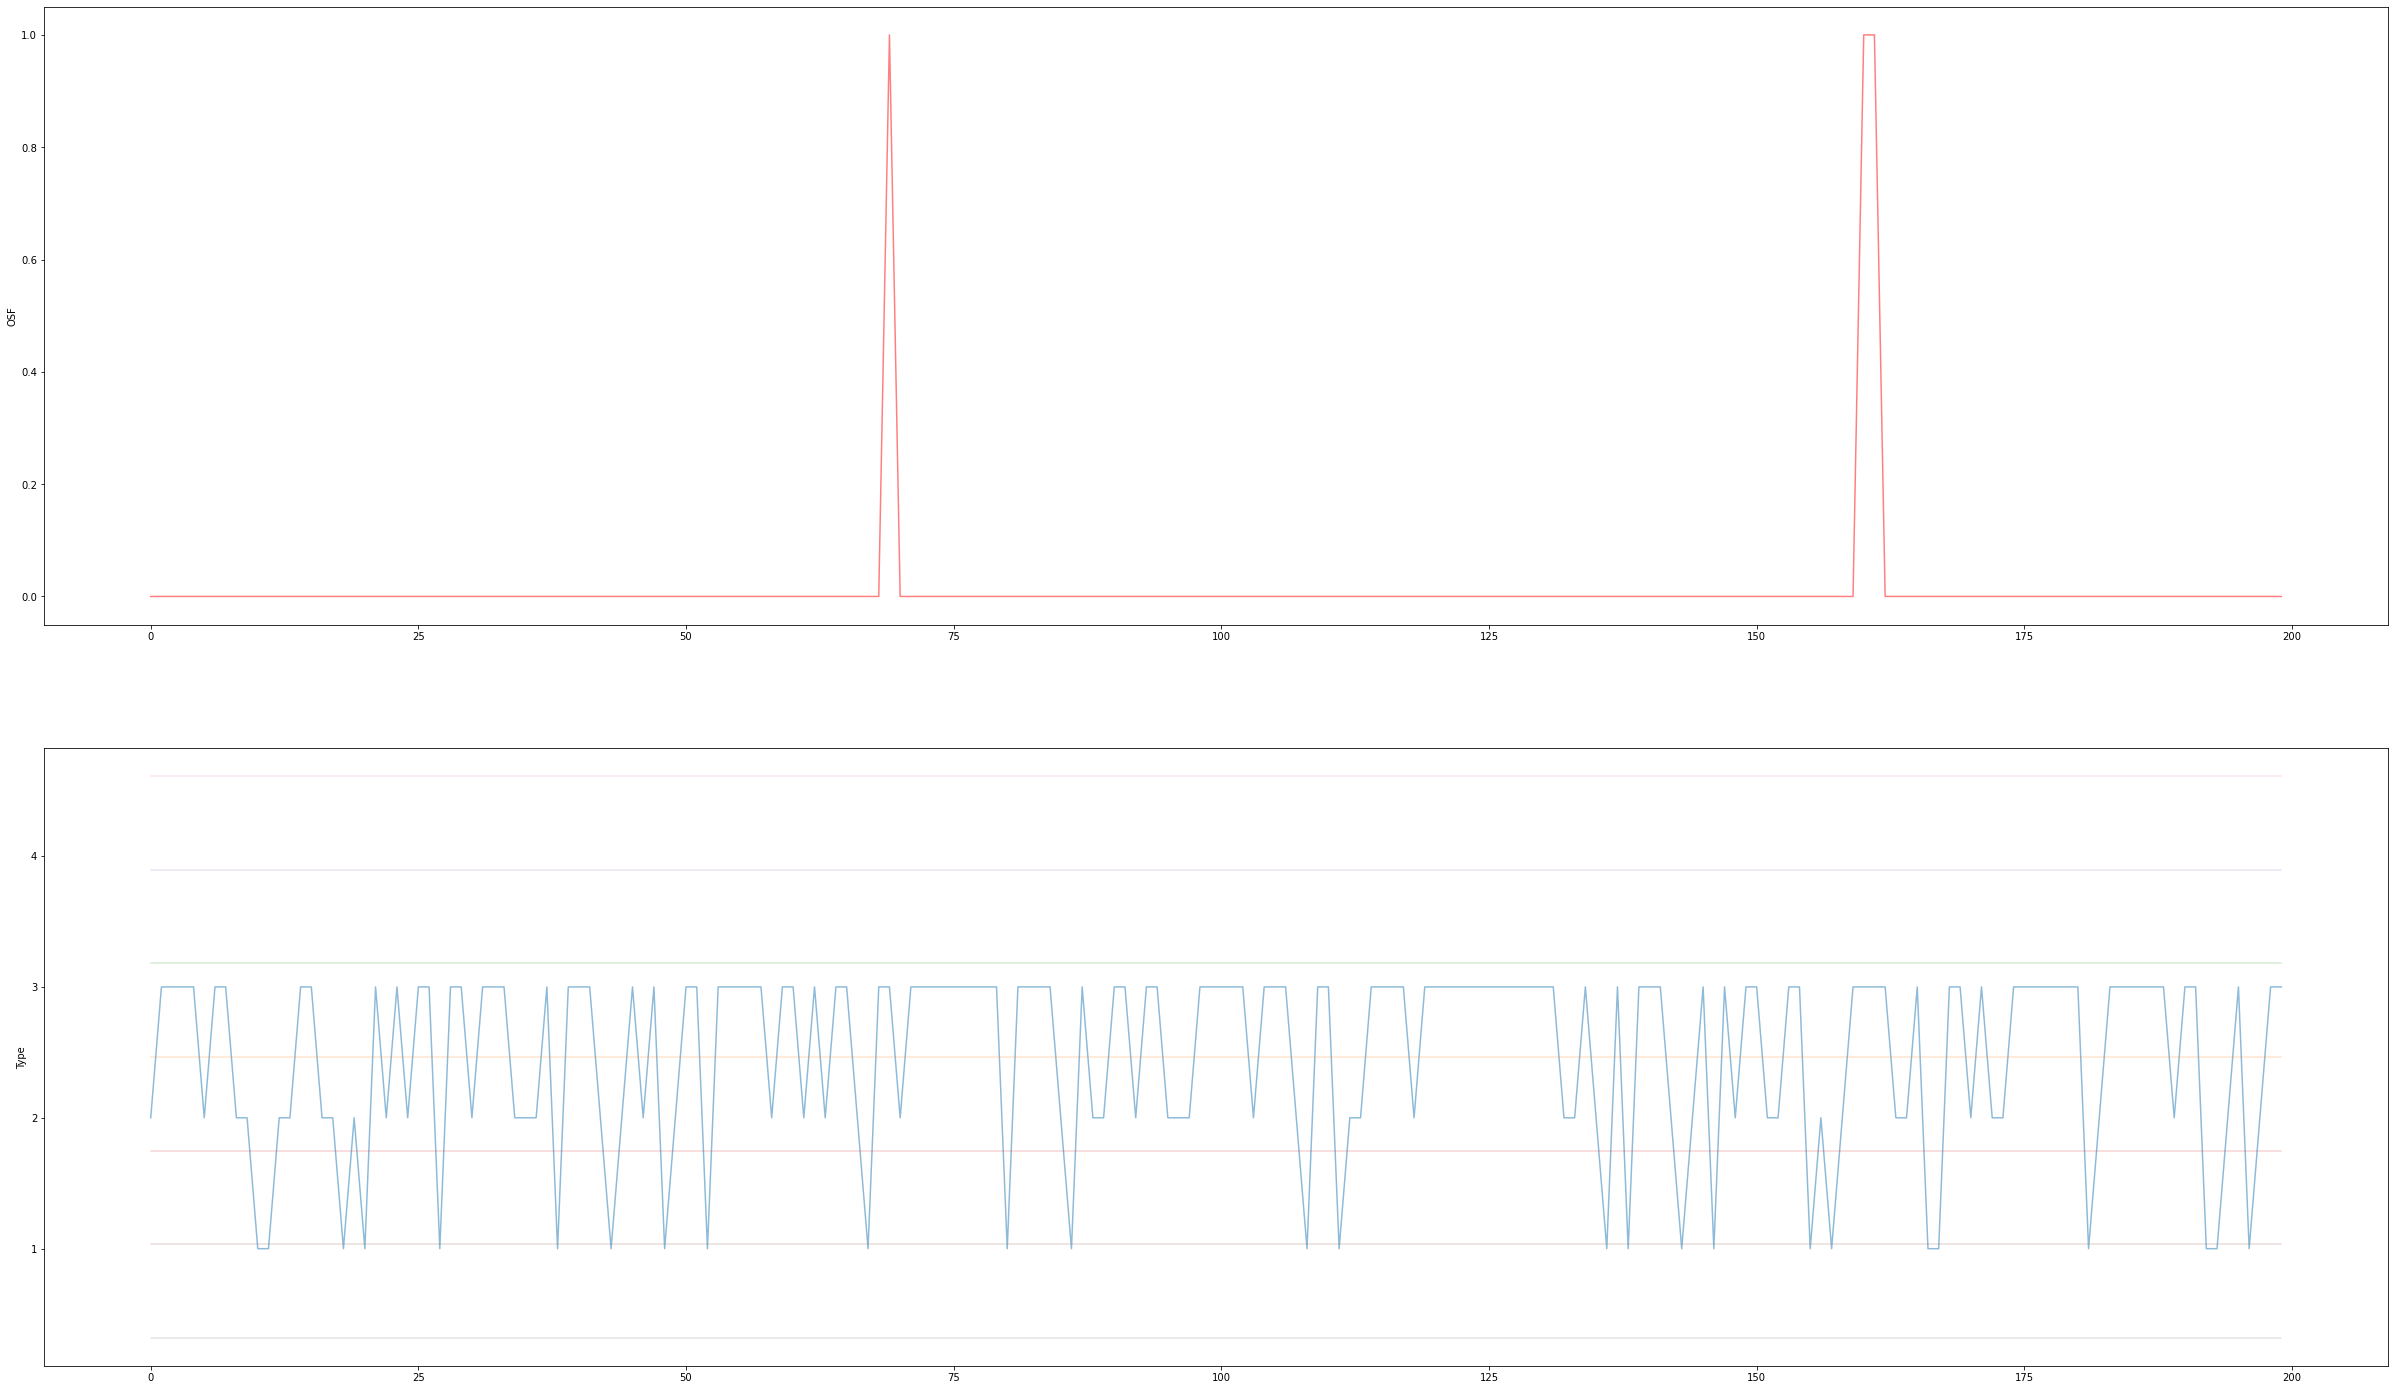

In [69]:
df_plot = df[0:200]
plot_feature_class(df_plot, ['Type'],'OSF')

# Genetic Algorithms to find the prediction pattern

## encoder function

In [32]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df, is_print_info=False):
    
    mean = np.mean(df)
    std = np.std(df)
    
    if is_print_info:
        print(f'mean: {mean}')
        print(f'std: {std}')
        print(f'a: {mean - (3*std)}')
        print(f'b: {mean - (2*std)}')
        print(f'c: {mean - (1*std)}')
        print(f'd: {mean}')
        print(f'e: {mean + (1*std)}')
        print(f'f: {mean + (2*std)}')
        print(f'g: {mean + (3*std)}')
    
    encoder_list = []
    
    for data_point in df:
        
        if is_print_info:
            print(data_point)
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
            
        if data_point <= (mean + (3*std)):
            encoder_list.append('g')
            continue   
                        
        encoder_list.append('h')

    return encoder_list

In [33]:
test_encoder = encode_feature(df['Torque'], False)
test_encoder[100:110]

['c', 'c', 'e', 'e', 'e', 'd', 'e', 'e', 'd', 'd']

### Generate the random genome by specific length

In [34]:
def generate_genome(genome_length:int=5, num_pattern:int=1):
    
    
    previous_gene = ''
    or_logic = False
    count_or = 0
    genome_group = []
    
    for j in range(num_pattern):
        
        genome = []
        for i in range(genome_length):

            # First character should not be symbol
            if i == 0:
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # Last character should not be symbol
            if i == (genome_length-1):
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # If previous character is symbol then next character should not be symbol
            if previous_gene[0] == '.*' or previous_gene[0] == '|':
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene

                if previous_gene[0] == '|':
                    or_logic = True
                    count_or = 2

                previous_gene = next_gene
                continue

            if count_or > 0:
                next_gene = choices(['a','b','c','d','e','f','g','h'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                count_or = count_or - 1
                continue

            next_gene = choices(['a','b','c','d','e','f','g','h','.*','|'], k=1)            
            genome = genome + next_gene
            previous_gene = next_gene
        genome_group.append(genome) 
    
    return genome_group

In [35]:
test_genome = generate_genome(genome_length=5, num_pattern=1)
test_genome

[['d', 'c', 'f', 'd', 'f']]

### Generate the population

In [36]:
def generate_population(size, genome_lenght, num_pattern=1, num_feature=1):
    return [generate_genome(genome_lenght, num_pattern) for _ in range(size)]

In [37]:
test_population = generate_population(size=10, genome_lenght=2, num_pattern=3)
for genome in test_population:
    print(genome)

[['e', 'b'], ['a', 'h'], ['c', 'a']]
[['b', 'h'], ['g', 'h'], ['d', 'e']]
[['e', 'b'], ['h', 'f'], ['h', 'b']]
[['c', 'b'], ['d', 'b'], ['e', 'g']]
[['h', 'g'], ['b', 'd'], ['g', 'a']]
[['g', 'c'], ['h', 'h'], ['c', 'b']]
[['f', 'e'], ['c', 'd'], ['g', 'b']]
[['e', 'b'], ['d', 'e'], ['b', 'f']]
[['f', 'a'], ['d', 'a'], ['a', 'f']]
[['e', 'd'], ['a', 'f'], ['c', 'd']]


### Get expression

In [38]:
def get_expression(data, num_pattern):
    
    
    or_flag = False
    expression_group = []
    
    for j in range(num_pattern):
        reg_result = ""
        
        for idx, i in enumerate(data[j]):

            if i == '|' and reg_result == "":
                raise Exception(f"The symbol '|' can't be the first parameter: {data}")

            if i == '|' and (idx + 1) == len(data[j]):
                raise Exception(f"The symbol '|' can't be the last parameter: {data}")

            if i in ('a', 'b', 'c', 'd','e','f','g','h','.*') and or_flag == False:
                reg_result = reg_result + i
                buf = i
                continue

            if i in ('a', 'b', 'c', 'd','e','f','g','h','.*') and or_flag == True:
                reg_result = reg_result + f"{i}]"
                or_flag = False
                continue

            if or_flag == True and (i == '|' or i == '.*'):
                reg_result = reg_result + 'd'
                continue

            if i == '|':
                reg_result = reg_result[0:(len(reg_result)- len(buf))]
                reg_result = reg_result + f"[{buf}|"
                or_flag = True
                continue
                
        expression_group.append('.*'+reg_result+".*")
 
    return expression_group

In [39]:
test_genome[0]

['d', 'c', 'f', 'd', 'f']

In [40]:
test_expression = get_expression(test_genome, num_pattern=1)

print(test_expression)

['.*dcfdf.*']


### Encoded feature fortesting

In [41]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,Power,AirDiff,TorqueToolWear
0,1,M14860,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,66382.8,10.5,0.0
1,2,L47181,3,298.2,308.7,1408,46.3,3,0,0,0,0,0,65190.4,10.5,138.9


In [42]:
df_MF = df['MF']
df_TWF = df['TWF']
df_HDF = df['HDF']
df_PWF = df['PWF']
df_OSF = df['OSF']

df_torque = df['Torque']
df_speed = df['RotationalSpeed']
df_airtemp = df['AirTemp']
df_processtemp = df['ProcessTemp']
df_toolwear = df['ToolWear']
df_power = df['Power']
df_airdiff = df['AirDiff']

encoded_torque = encode_feature(df_torque)
encoded_speed = encode_feature(df_speed)
encoded_airtemp = encode_feature(df_airtemp)
encoded_processtemp = encode_feature(df_processtemp)
encoded_toolwear = encode_feature(df_toolwear)
encoded_power = encode_feature(df_power)
encoded_airdiff = encode_feature(df_airdiff)

### Calculate the fitness score

In [43]:
# This fitness function is support only OSF prediction. It will fix some range of AirDiff to predict next window able to has failed

def fitness_v4(genome, encoded_feature, df_OSF, window_size=20, is_print_info = False, num_pattern=1):

    if is_print_info:
        print(f'Input genome: {genome}')
    
    # Initial setting for window
    start = 0
    end = window_size
    number_round = int(len(encoded_feature)/window_size)-1
    
    if is_print_info:
        print(f'Number of round: {len(encoded_feature)}')
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Get reg function from genome
    reg_expression = get_expression(genome, num_pattern)
    
    if is_print_info:
        print(f'Current expression: {reg_expression[0]}')
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(number_round):
        
        # Start by predict the next window doesn't has failed
        predict_fail = False 

        # Get current pattern of feature by window size
        current_pattern = ''.join(encoded_feature[start:end])

        # Check regular matched
        matched = re.search(reg_expression[0], current_pattern)

        if matched is not None:
            predict_fail = True
        else:
            predict_fail = False

        # Find the next period will have the fail case or not
        fail_next_period = list(df_OSF[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1

        start += window_size
        end += window_size
        
    # Calculate accuracy
    if (TN + FP + TP + FN) == 0:
        accuracy = 0
    else:
        accuracy = (TN + TP)/(TN + FP + TP + FN)
        
    # Calculate recall    
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    # Calculate precision
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    # Calculate f1 score
    if (precision+recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall)/(precision+recall))
    
    return(f1_score, accuracy, precision, recall)

### Selection Pair

In [44]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [45]:
test_population

[[['e', 'b'], ['a', 'h'], ['c', 'a']],
 [['b', 'h'], ['g', 'h'], ['d', 'e']],
 [['e', 'b'], ['h', 'f'], ['h', 'b']],
 [['c', 'b'], ['d', 'b'], ['e', 'g']],
 [['h', 'g'], ['b', 'd'], ['g', 'a']],
 [['g', 'c'], ['h', 'h'], ['c', 'b']],
 [['f', 'e'], ['c', 'd'], ['g', 'b']],
 [['e', 'b'], ['d', 'e'], ['b', 'f']],
 [['f', 'a'], ['d', 'a'], ['a', 'f']],
 [['e', 'd'], ['a', 'f'], ['c', 'd']]]

In [46]:
weights = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
selected_genome = selection_pair(test_population, weights, number=2)
selected_genome

[[['e', 'b'], ['a', 'h'], ['c', 'a']], [['e', 'b'], ['a', 'h'], ['c', 'a']]]

### Cross Over

In [47]:
def single_point_cross_over(genome1, genome2, num_pattern=1):
    
    is_print_info = False
    
    if is_print_info:
        print(f'This is genome1: {genome1}')
        print(f'This is genome2: {genome2}')
    
    genome_result1 = []
    genome_result2 = []

    
    for i in range(num_pattern):
        if len(genome1[i]) != len(genome2[i]):
            print(genome1[i])
            print(genome2[i])
            raise ValueError("Genomes 1 and 2 must be of same length")

        length = len(genome1[i])

        if length < 2:
            offspring1 = genome1[i]
            offspring2 = genome2[i]

        if length >= 2:    
            position = randint(1, length-1)
            offspring1 = genome1[i][0:position] + genome2[i][position:]
            offspring2 = genome2[i][0:position] + genome1[i][position:]
        
        genome_result1.append(offspring1)
        genome_result2.append(offspring2)
        
        
    if is_print_info:
        print('after')
        print(f'This is genome1: {genome_result1}')
        print(f'This is genome2: {genome_result2}')
        print('*'*30)
    
    return genome_result1, genome_result2

In [48]:
test_genome1 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10], [11,12,13,14,15]]
test_genome2 = [[15,14,13,12,11],[10, 9 , 8, 7, 6], [5, 4, 3, 2, 1]]

print(single_point_cross_over(test_genome1, test_genome2, num_pattern=3))

([[1, 14, 13, 12, 11], [6, 7, 8, 9, 6], [11, 12, 13, 2, 1]], [[15, 2, 3, 4, 5], [10, 9, 8, 7, 10], [5, 4, 3, 14, 15]])


### Mutation

In [49]:
def mutation(genome, number=1, num_pattern=1):
    for i in range(num_pattern):
        for _ in range(number):
            index = randrange(len(genome[i]))
            genome[i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [50]:
test_genome3 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10]]
new = mutation(test_genome3)
new

[[1, 2, 'a', 4, 5], [6, 7, 8, 9, 10]]

### Evolution

In [51]:
# This is evolution function to use for only OSF prediction.
def run_evolution_v4(encoded_feature, df_OSF ,window_size, generation_limit=100, population_size=10, genome_length=10, num_pattern=1, is_print_log=False):
    
    best_ever_max_score = 0
    best_ever_pattern = []
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_length, num_pattern=num_pattern)
    
    if is_print_log:
        print(f'first population {population}')
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        # f1_score:0, accuracy:1, precision:2, recall:3
        fitness_scores = [fitness_v4(genome, encoded_feature, df_OSF=df_OSF, window_size=window_size, is_print_info=False, num_pattern=num_pattern)[0] for genome in population]

        max_score = max(fitness_scores)
        
        if max_score > best_ever_max_score:
            best_ever_max_score = max_score
            
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            best_ever_pattern = population_and_score[0][1]
                
        if is_print_log:
            print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')
            
        if is_print_log and False:   
            print('*'*50)
            population_and_score = list(zip(fitness_scores, population))
            print(f'population and score: {population_and_score}')
            print('*'*50)

        # 2. Evaluation
        if max_score >= 0.8:
            population_and_score = list(zip(fitness_scores, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        if sum(fitness_scores) == 0:
            adjust_score = [1 for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
        else:
            adjust_score = [i for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, population_size)
            
            if is_print_log and False:   
                print('*'*50)
                print(f'new population: {new_population}')
                print('*'*50)

        # 4. Crossover
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
                offspring1, offspring2 = single_point_cross_over(genome, other_genome, num_pattern=num_pattern)
            else:
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()

        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                
                is_show_mutation_log = False
                
                if is_show_mutation_log:  
                    print(f'Mutation !!!')
                    print(f'before: {new_population[idx]}')
                
                new_population[idx] = mutation(genome, num_pattern=num_pattern)
                
                if is_show_mutation_log:  
                    print(f'after: {new_population[idx]}')
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness_v4(genome, encoded_feature, df_OSF=df_OSF, window_size=window_size, is_print_info=False, num_pattern=num_pattern)[0] for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            
            f1_score, accuracy, precision, recall = fitness_v4(top_population[1], encoded_feature, df_OSF=df_OSF, window_size=window_size, num_pattern=num_pattern)
            #print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern])
        

In [53]:
df_torque_toolwear = df['TorqueToolWear']
encoded_feature = encode_feature(df_torque_toolwear)

In [55]:
top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern] = run_evolution_v4(
    encoded_feature=encoded_feature, 
    df_OSF=df_OSF,  
    window_size=20,
    generation_limit=5000,
    population_size=10,
    genome_length=5,
    num_pattern=1,
    is_print_log=True
)

first population [[['e', '|', 'd', 'c', 'g']], [['b', 'f', 'd', 'a', 'a']], [['f', '|', 'g', 'e', 'd']], [['b', 'b', 'd', 'c', 'g']], [['e', 'f', 'h', 'g', 'e']], [['b', '|', 'a', 'd', 'f']], [['a', 'f', 'g', 'g', 'b']], [['c', 'f', 'c', '.*', 'e']], [['g', 'a', '.*', 'd', 'h']], [['f', 'e', 'c', 'g', 'c']]]
round 0 has max score 0.14117647058823532.
round 1 has max score 0.14117647058823532.
round 2 has max score 0.14117647058823532.
round 3 has max score 0.14117647058823532.
round 4 has max score 0.14117647058823532.
round 5 has max score 0.14117647058823532.
round 6 has max score 0.14117647058823532.
round 7 has max score 0.14117647058823532.
round 8 has max score 0.14117647058823532.
round 9 has max score 0.14117647058823532.
round 10 has max score 0.14117647058823532.
round 11 has max score 0.14117647058823532.
round 12 has max score 0.14117647058823532.
round 13 has max score 0.14117647058823532.
round 14 has max score 0.14117647058823532.
round 15 has max score 0.141176470588235

In [57]:
#top_population, f1_score, accuracy, precision, recall, [best_ever_max_score, best_ever_pattern] 
print(f'best_score: {best_ever_max_score}, best_ever_pattern:{best_ever_pattern}')

best_score: 0.49773755656108604, best_ever_pattern:[['e', '|', 'd', 'e', 'f']]


### Test 1 Feature

In [62]:
def generate_report(max_pattern_length,window_sizes, encoded_feature, df_OSF, generation_limit, is_print_log):
    df_report = pd.DataFrame(columns = ['window_size','pattern_length','Pattern','F1','Accuracy','Precision','Recall'])
                           
    for genome_length in range(5,max_pattern_length+1):
        for window_size in window_sizes:

            if genome_length >= window_size:
                continue

            top_population, f1_score, accuracy, precision, recall, best_ever = run_evolution_v4(
                    encoded_feature=encoded_feature, 
                    df_OSF=df_OSF,  
                    window_size=window_size,
                    generation_limit=generation_limit,
                    population_size=10,
                    genome_length=genome_length,
                    num_pattern=1,
                    is_print_log=is_print_log
                )

            data = [window_size,genome_length, top_population, f1_score, accuracy, precision, recall]

            try:
                df_report.loc[len(df_report)] = data
                print(f'complete for window_size {window_size}  and genome_length {genome_length}.')
            except Exception as e:
                print(f'error for window_size {window_size} and genome_length {genome_length}.')
                print('*'*50)
                print(e)
                print('*'*50)
                
    return df_report
                             
                             
    

In [63]:
df_report = generate_report(
        max_pattern_length=20,
        window_sizes=[15, 20, 25, 30], 
        encoded_feature=encoded_feature,
        df_OSF=df_OSF, 
        generation_limit=10, 
        is_print_log=False
)

Mutation !!!
before: [['e', 'a', 'd', '|', 'f']]
after: [['e', 'a', 'd', 'c', 'f']]
complete for window_size 15  and genome_length 5.
Mutation !!!
before: [['e', 'b', 'a', 'e', 'f']]
after: [['e', 'b', 'a', 'e', 'a']]
Mutation !!!
before: [['e', 'b', 'a', 'e', 'g']]
after: [['e', 'b', 'a', 'e', 'e']]
complete for window_size 20  and genome_length 5.
Mutation !!!
before: [['f', 'c', 'g', 'e', 'a']]
after: [['f', 'c', 'g', 'g', 'a']]
Mutation !!!
before: [['e', 'c', 'f', 'b', 'c']]
after: [['e', 'c', 'f', 'b', 'a']]
Mutation !!!
before: [['e', 'c', 'g', 'b', 'b']]
after: [['e', 'c', 'g', 'a', 'b']]
complete for window_size 25  and genome_length 5.
Mutation !!!
before: [['d', 'b', 'f', 'e', 'b']]
after: [['d', 'f', 'f', 'e', 'b']]
Mutation !!!
before: [['e', 'b', 'f', 'e', 'b']]
after: [['e', 'b', 'a', 'e', 'b']]
Mutation !!!
before: [['e', 'b', 'f', 'e', 'b']]
after: [['e', 'b', 'f', 'e', 'g']]
Mutation !!!
before: [['e', 'b', 'f', 'e', 'b']]
after: [['e', 'b', 'f', 'e', 'f']]
Mutation !

KeyboardInterrupt: 

In [316]:
df_report.sort_values(by=['F1'], ascending=False)

,window_size,pattern_length,Pattern,F1,Accuracy,Precision,Recall
5,20,6,"(0.49253731343283585, [[f, .*, h, |, d, e]])",0.492537,0.829574,0.358696,0.785714
4,15,6,"(0.4732142857142857, [[e, c, |, e, |, d]])",0.473214,0.778195,0.309942,1.000000
2,25,5,"(0.15, [[f, b, .*, e, c]])",0.15,0.893417,0.6,0.085714
0,15,5,"(0, [[e, h, g, a, h]])",0,0.900376,0,0.000000
43,20,16,"(0, [[f, .*, b, d, d, f, g, |, d, f, a, e, f, ...",0,0.894737,0,0.000000
32,15,13,"(0, [[f, d, b, h, a, h, f, f, b, g, b, .*, b]])",0,0.900376,0,0.000000
33,20,13,"(0, [[e, h, h, .*, c, a, h, c, d, b, h, .*, c]])",0,0.894737,0,0.000000
34,25,13,"(0, [[f, f, f, c, a, g, |, f, |, b, a, a, g]])",0,0.890282,0,0.000000
35,30,13,"(0, [[f, b, c, g, e, d, |, b, e, c, a, d, c]])",0,0.886792,0,0.000000
36,15,14,"(0, [[d, |, h, g, h, c, a, f, .*, .*, d, h, h,...",0,0.900376,0,0.000000


### Generate Report

In [274]:
test_features = [encoded_power]

result = generate_report(
    max_pattern_group=10,
    max_pattern_length=20,
    window_sizes= [5,  10,  15, 20],
    df_state=df_PWF,
    encoded_feautes=encoded_features,
    num_loop=5,
    print_log=False
)

complete for window_size 10 number_group 1 and genome_length 5.
complete for window_size 15 number_group 1 and genome_length 5.
complete for window_size 20 number_group 1 and genome_length 5.
complete for window_size 10 number_group 1 and genome_length 6.
complete for window_size 15 number_group 1 and genome_length 6.
complete for window_size 20 number_group 1 and genome_length 6.
complete for window_size 10 number_group 1 and genome_length 7.
complete for window_size 15 number_group 1 and genome_length 7.
complete for window_size 20 number_group 1 and genome_length 7.
complete for window_size 10 number_group 1 and genome_length 8.
complete for window_size 15 number_group 1 and genome_length 8.
complete for window_size 20 number_group 1 and genome_length 8.
complete for window_size 10 number_group 1 and genome_length 9.
complete for window_size 15 number_group 1 and genome_length 9.
complete for window_size 20 number_group 1 and genome_length 9.
complete for window_size 15 number_group

In [277]:
pd.set_option('display.max_rows', None)
result.sort_values(by=['F1'], ascending=False)

,window_size,num_group,pattern_length,Pattern,F1,Accuracy,Precision,Recall
35,20,2,6,"[[d, c, |, c, |, d], [e, d, c, d, e, f]]",0.323009,0.233083,0.193634,0.973333
2,20,1,5,"[[d, .*, c, |, c]]",0.318707,0.260652,0.192737,0.920000
64,15,3,6,"[[f, |, d, e, |, f], [a, d, .*, e, e, a], [f, ...",0.316456,0.187970,0.187970,1.000000
62,20,3,5,"[[f, |, d, .*, d], [e, d, f, |, d], [a, |, b, ...",0.316456,0.187970,0.187970,1.000000
65,20,3,6,"[[c, e, g, b, d, e], [c, |, c, .*, e, e], [d, ...",0.314199,0.431078,0.203125,0.693333
31,15,2,5,"[[d, c, d, |, e], [g, a, d, a, b]]",0.312757,0.581454,0.226190,0.506667
10,15,1,8,"[[d, .*, d, .*, d, d, .*, f]]",0.312000,0.568922,0.222857,0.520000
34,15,2,6,"[[e, .*, e, e, |, g], [a, f, a, |, e, f]]",0.298734,0.305764,0.184375,0.786667
5,20,1,6,"[[e, g, |, b, |, d]]",0.297593,0.195489,0.178010,0.906667
60,10,3,5,"[[g, .*, e, f, g], [f, a, c, g, f], [a, |, d, ...",0.286645,0.451128,0.189655,0.586667


In [278]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/result_PWF_(power)_1000.csv'
result.to_csv(file_path, index=None)

In [ ]:
.....bedc...... ---> Fail

In [ ]:
.....bedb......

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [263]:
randint(1, 10)

2

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight